In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from datetime import datetime

[*********************100%%**********************]  1 of 1 completed


Dataset length- 152  | Training len- 137  | Default prediction len- 15  | Custom Prediction len- 5


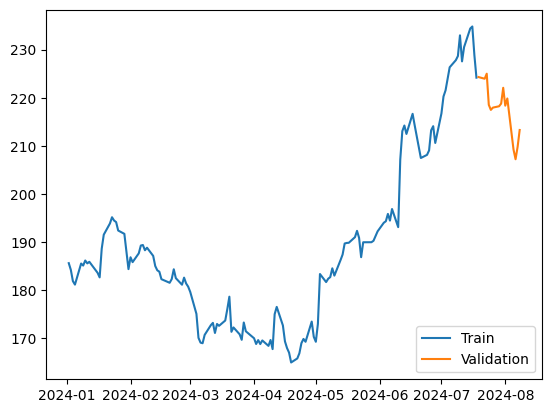

In [2]:
prediction_data_len =5
start_date = '2024-01-01'
end_date = datetime.now()
df_detail = yf.download("AAPL", start_date, end_date)

#sns.lineplot(df_detail, x='Date', y='Close')
data = df_detail.filter(['Close'])
training_data_len = int(np.ceil( len(data) * .90 ))   # set train len to 1 for pred

print('Dataset length-', len(data), ' | Training len-', training_data_len, ' | Default prediction len-', len(data)-training_data_len, ' | Custom Prediction len-', prediction_data_len)
train_data = data.iloc[0:int(training_data_len), :]
val_data = data.iloc[training_data_len: , :]

plt.plot(train_data['Close'])
plt.plot(val_data[['Close']])
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [3]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_ar = scaler.fit_transform(train_data)

x_train = []
y_train = []

for i in range(6, len(train_ar)):
    x_train.append(train_ar[i-6:i, 0])
    y_train.append(train_ar[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(131, 6, 1)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0251
Epoch 2/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0091
Epoch 3/3
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0107


In [5]:
######## Note last part of train data should be used as input to generate predictions.
######## so test_ar is last part of train
test_start_len=training_data_len-prediction_data_len-6
test_ar = train_ar[ test_start_len :, :]

x_test = []
for i in range(6, len(test_ar)):
    x_test.append(test_ar[i-6:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))  # Reshape the data

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
start_date = train_data.index.max() + pd.Timedelta(days=1)
date_index = pd.date_range(start=start_date, periods=len(predictions), freq='D')
predictions_df = pd.DataFrame(predictions, index=date_index, columns=['Close'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


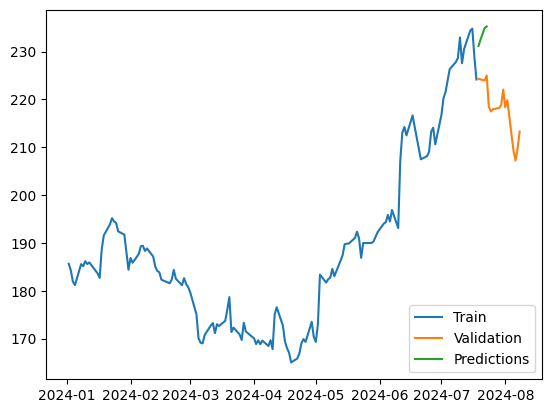

In [6]:
plt.plot(train_data['Close'])
plt.plot(val_data['Close'])
plt.plot(predictions_df['Close'])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

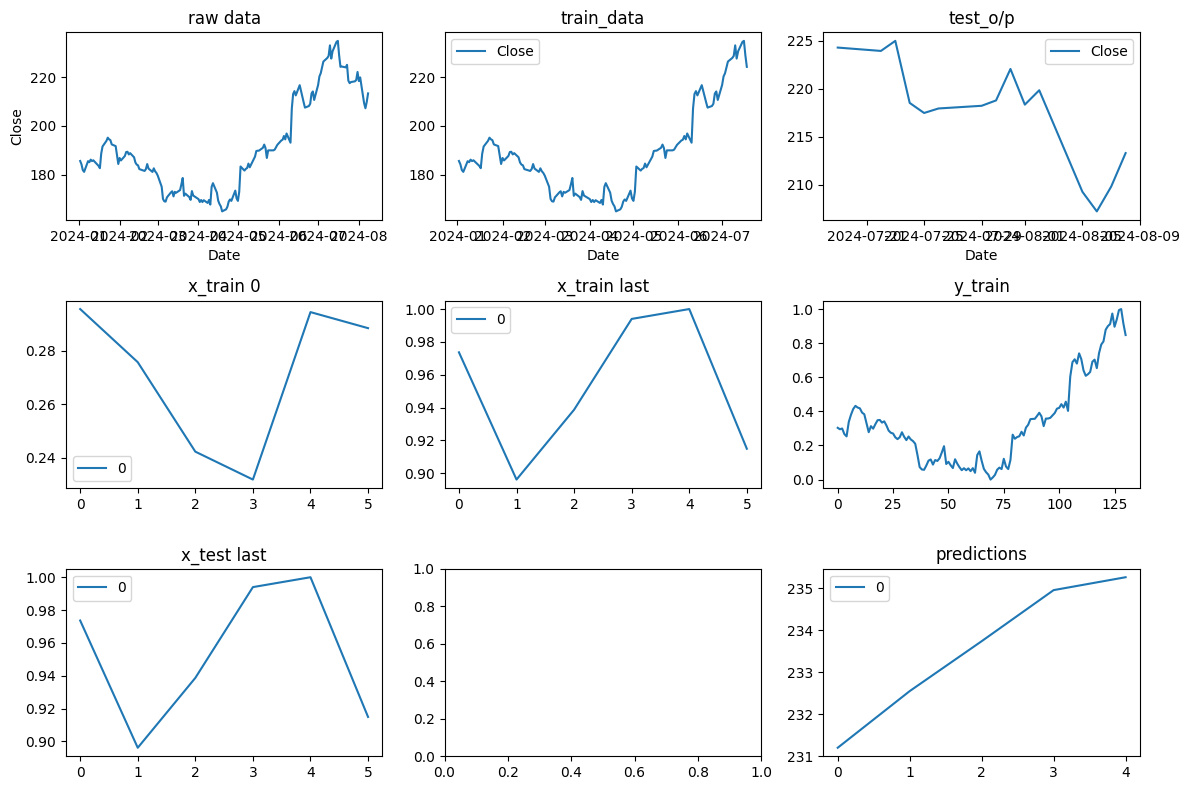

In [9]:
fig, axes = plt.subplots(3,3,figsize=(12,8))
sns.lineplot(df_detail, x='Date', y='Close' , ax=axes[0,0]).set_title('raw data')
sns.lineplot(train_data , ax=axes[0,1]).set_title('train_data')
sns.lineplot(val_data , ax=axes[0,2]).set_title('test_o/p')
sns.lineplot(x_train[0] , ax=axes[1,0]).set_title('x_train 0')
sns.lineplot(x_train[-1] , ax=axes[1,1]).set_title('x_train last')
sns.lineplot(y_train , ax=axes[1,2]).set_title('y_train')
sns.lineplot(x_test[-1] , ax=axes[2,0]).set_title('x_test last')
sns.lineplot(predictions , ax=axes[2,2]).set_title('predictions')

plt.tight_layout()
plt.show()